# Bots trading analysis

## Round 4
- COCONUT: Raj, Vinnie
- COCONUT_COUPON: Valentina, Vinnie, Vladimir 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

In [25]:
# Bots that start with the same letter are from the same snake family
bots = ["Valentina", "Vinnie", "Vladimir", "Vivian", 
       "Celeste", "Colin", "Carlos", "Camilla", 
       "Pablo", "Penelope", "Percy", "Petunia",
       "Ruby", "Remy", "Rhianna", "Raj",
       "Amelia", "Adam", "Alina", "Amir"]


bot_colours = [
    "#FF0000", "#FF3300", "#FF6600", "#FF9900",
    "#FFA500", "#FFC400", "#FFD700", "#FFEC80",
    "#FFFF00", "#FFFF80", "#FFFFBF", "#FFFFE0",
    "#008000", "#00AA00", "#00CC00", "#00FF00",
    "#0000FF", "#3366FF", "#6699FF", "#99CCFF"
]

# Read data
round_num = 3
day_num = 2

csv_file_path_trades = f"./data/round_{round_num}/trades_round_{round_num}_day_{day_num}_wn.csv"
csv_file_path_orders = f"./data/round_{round_num}/prices_round_{round_num}_day_{day_num}.csv"

df_trades = pd.read_csv(csv_file_path_trades, sep=';')
df_orders = pd.read_csv(csv_file_path_orders, sep=';')

products = np.unique(df_trades['symbol'])

buy_trades  = {}
sell_trades = {}
orders = {}

for prod in products:
    buy_trades[prod] = {}
    sell_trades[prod] = {}
    for b in bots:
        buy_trades[prod][b] = df_trades[(df_trades['symbol'] == prod) & ((df_trades['buyer'] == b))]
        sell_trades[prod][b] = df_trades[(df_trades['symbol'] == prod) & ((df_trades['seller'] == b))]
        
    orders[prod] = df_orders[df_orders['product'] == prod]

# Direct proportionat cu volum

In [26]:
def plot_trades(trades, prod, range, title=""):
    fig, ax = plt.subplots(figsize=(11, 6))

    for b, c in zip(bots, bot_colours):
        if len(trades[prod][b]) == 0:
            continue
            
        time_mask = ((trades[prod][b]['timestamp'] > range[0]) 
                     & (trades[prod][b]['timestamp'] < range[1]))
        
        ax.scatter(trades[prod][b]['timestamp'][time_mask],
                   trades[prod][b]['price'][:range[1]][time_mask], 
                   label=b, color=c, s=trades[prod][b]['quantity'][time_mask] * 10)
        
    time_mask = ((orders[prod]['timestamp'] > range[0]) 
                 & (orders[prod]['timestamp'] < range[1]))
    ax.plot(orders[prod]['timestamp'][time_mask], 
            orders[prod]['mid_price'][time_mask], 
            label='mid price', color='black', linestyle='--', alpha=0.5)
    plt.title(title)
    ax.legend()
    plt.show()

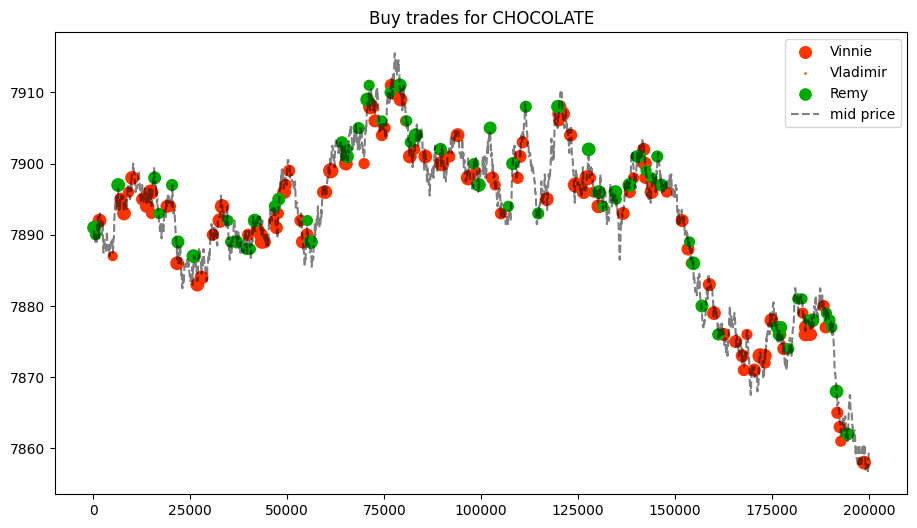

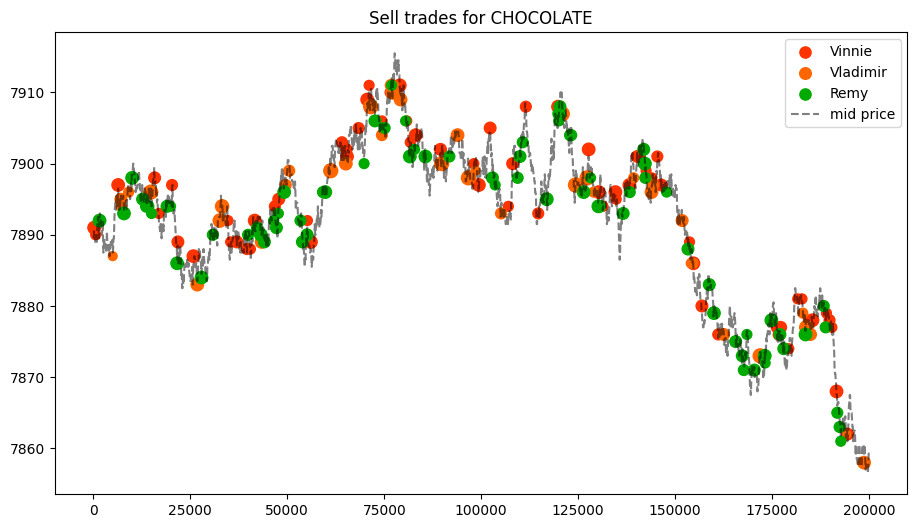

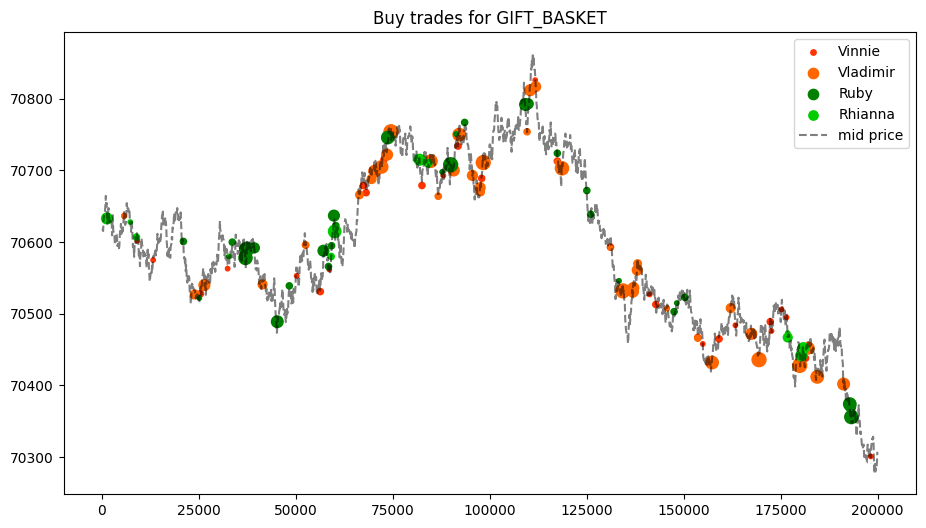

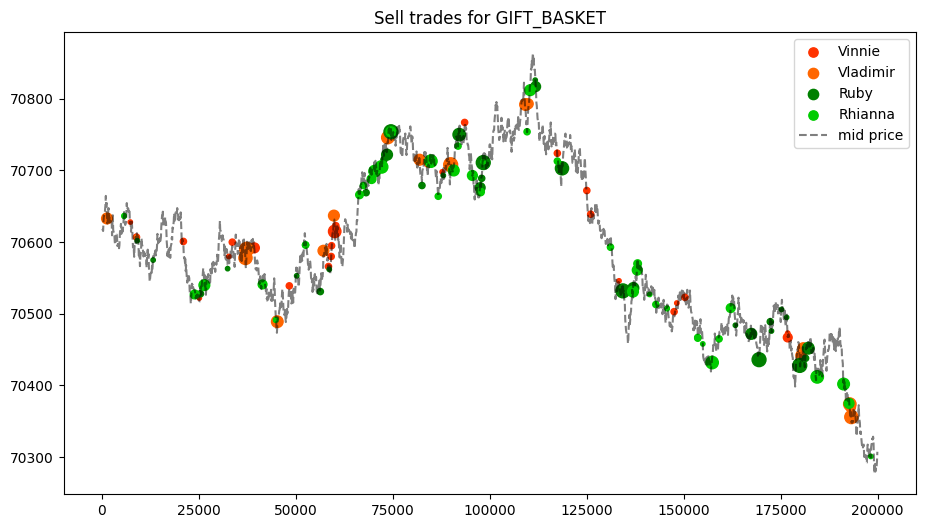

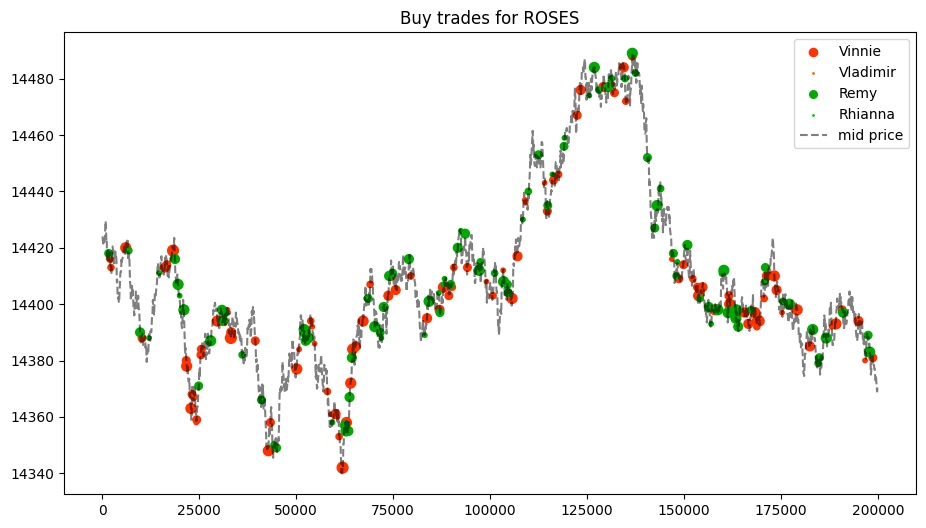

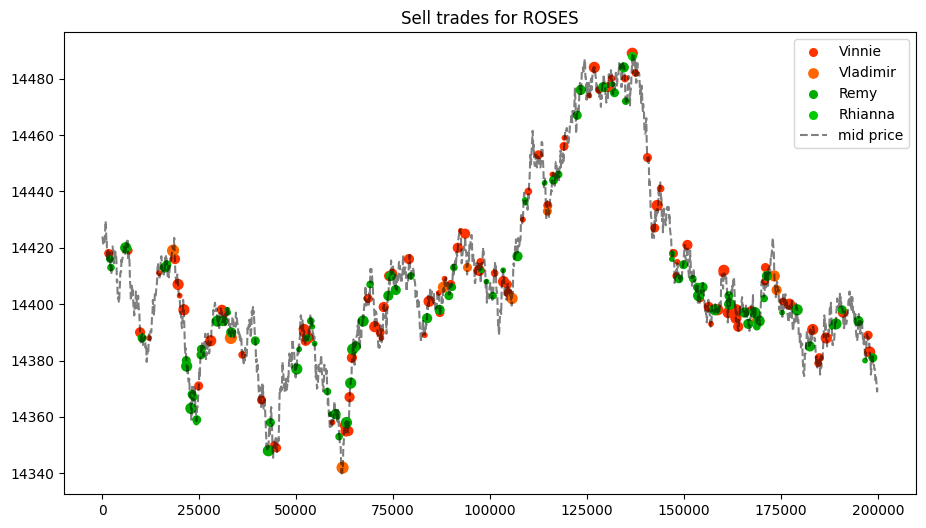

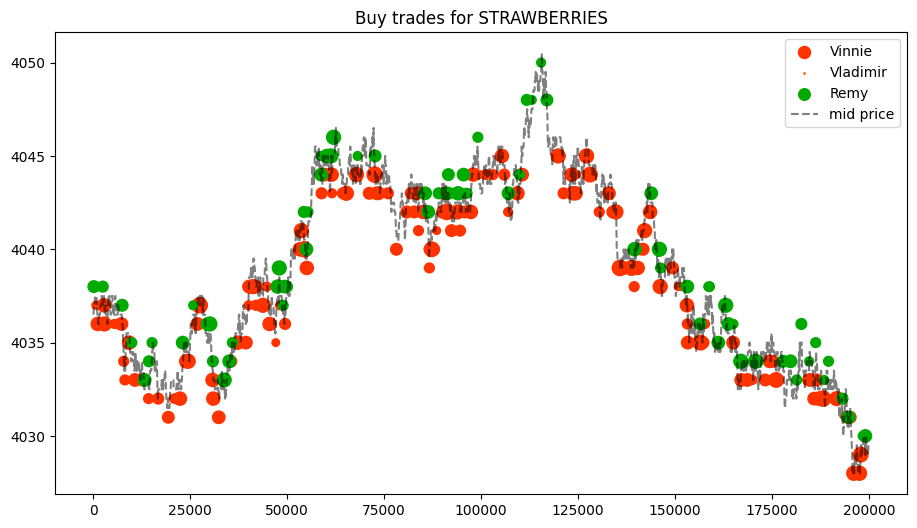

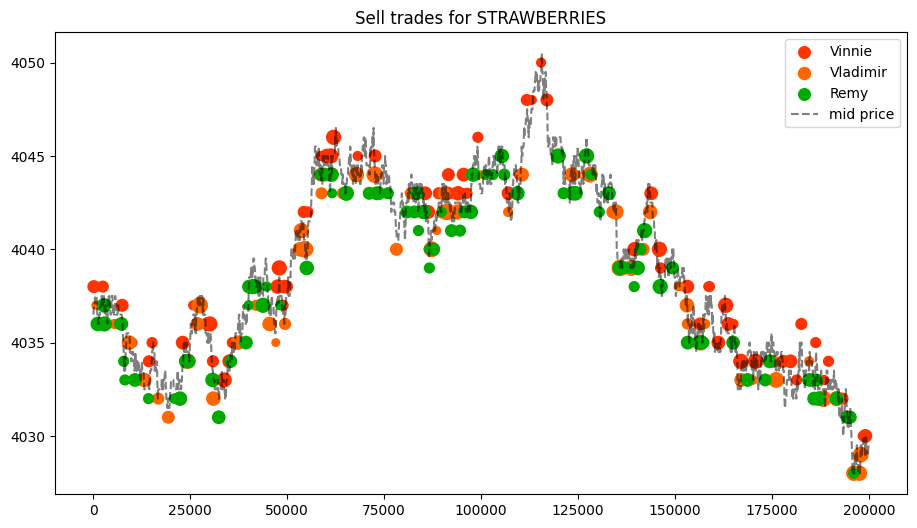

In [27]:
for prod in np.unique(df_trades['symbol']):
    time_range = (0, 200000)
    plot_trades(buy_trades, prod, time_range, title=f"Buy trades for {prod}")
    plot_trades(sell_trades, prod, time_range, title=f"Sell trades for {prod}")